In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import scipy
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Flatten, MaxPooling2D, Dense, BatchNormalization, add, Activation
from tensorflow.keras import optimizers, losses
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50


from pathlib import Path
import os.path


from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import itertools

In [3]:
data = r"C:\Users\HP\OneDrive\Desktop\code\augmented-alzheimer-mri-dataset"

In [4]:
image_dir = Path(data)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) 

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)

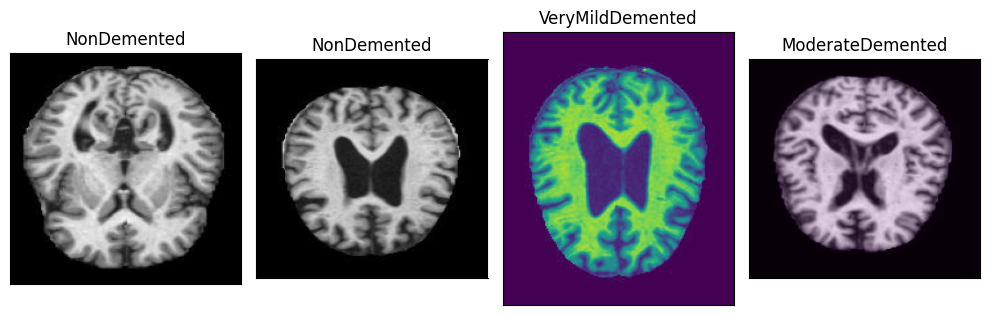

In [5]:
# Displaying 4 random images
random_index = np.random.randint(0, len(image_df), 4)
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
    )

test_datagen = ImageDataGenerator(
    rescale=1./255)

In [7]:
train_dir = r"C:\Users\HP\OneDrive\Desktop\code\augmented-alzheimer-mri-dataset\AugmentedAlzheimerDataset"
test_dir = r"C:\Users\HP\OneDrive\Desktop\code\augmented-alzheimer-mri-dataset\OriginalDataset"

In [8]:
train_images = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

validation_images = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    subset='validation'
)

test_images = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 27188 images belonging to 4 classes.
Found 6796 images belonging to 4 classes.
Found 5728 images belonging to 4 classes.


In [9]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Flatten, Dense

# Load MobileNetV2 as the base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom dense layers on top of the base model
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
output = Dense(4, activation='softmax')(x)

# Define the new model with the base model and top layers
model = tf.keras.models.Model(inputs=base_model.input, outputs=output)

# Freeze the weights of the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False


In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [11]:
model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(), metrics = ['accuracy'])
history = model.fit(train_images,
    steps_per_epoch=len(train_images),
    validation_data=validation_images,
    validation_steps=len(validation_images),
    epochs=20)

Epoch 1/20
850/850 [==============================] - 510s 597ms/step - loss: 1.1288 - accuracy: 0.7178 - val_loss: 0.5999 - val_accuracy: 0.7632
Epoch 2/20
850/850 [==============================] - 489s 576ms/step - loss: 0.3456 - accuracy: 0.8623 - val_loss: 0.2971 - val_accuracy: 0.8858
Epoch 3/20
850/850 [==============================] - 489s 575ms/step - loss: 0.2379 - accuracy: 0.9095 - val_loss: 0.4373 - val_accuracy: 0.8445
Epoch 4/20
850/850 [==============================] - 490s 576ms/step - loss: 0.2029 - accuracy: 0.9239 - val_loss: 0.4278 - val_accuracy: 0.8498
Epoch 5/20
850/850 [==============================] - 475s 559ms/step - loss: 0.1772 - accuracy: 0.9339 - val_loss: 0.2637 - val_accuracy: 0.9113
Epoch 6/20
850/850 [==============================] - 471s 554ms/step - loss: 0.1473 - accuracy: 0.9464 - val_loss: 0.2280 - val_accuracy: 0.9189
Epoch 7/20
850/850 [==============================] - 480s 564ms/step - loss: 0.1031 - accuracy: 0.9628 - val_loss: 0.2929 -

179/179 [==============================] - 79s 435ms/step


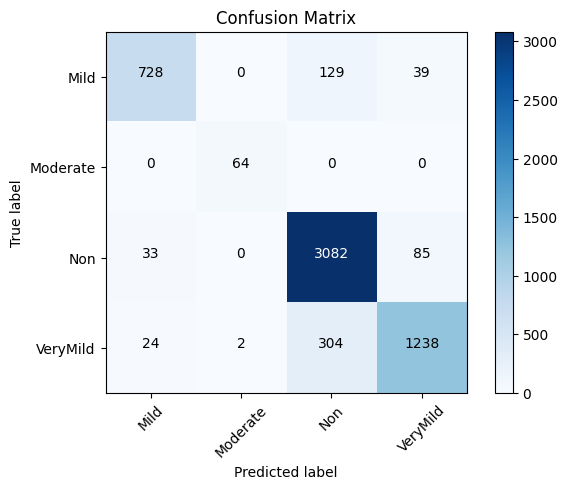

In [12]:
from itertools import product

# Get the predictions for the validation data
Y_pred = model.predict(test_images)

# Convert the predictions from one-hot encoding to labels
y_pred = np.argmax(Y_pred, axis=1)
# Get the true labels for the validation data
y_true = test_images.classes

# Create the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

# Define the class labels
class_names = ['Mild', 'Moderate', 'Non', 'VeryMild']

# Plot the confusion matrix
plt.imshow(confusion_mtx, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
fmt = 'd'
thresh = confusion_mtx.max() / 2.
for i, j in product(range(confusion_mtx.shape[0]), range(confusion_mtx.shape[1])):
    plt.text(j, i, format(confusion_mtx[i, j], fmt),
             horizontalalignment="center",
             color="white" if confusion_mtx[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [13]:
print(accuracy_score(y_true, y_pred))
test_accuracy = accuracy_score(y_true, y_pred)

0.8924581005586593


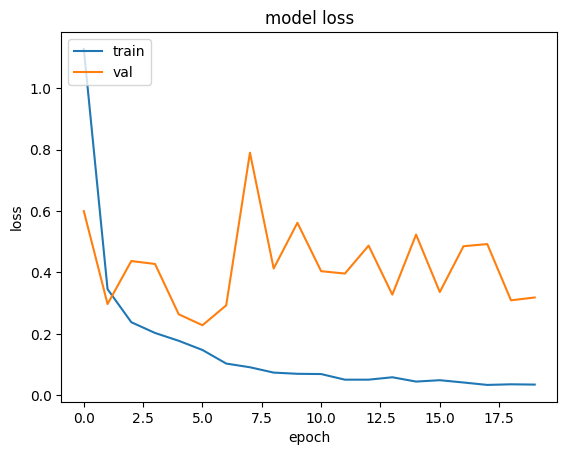

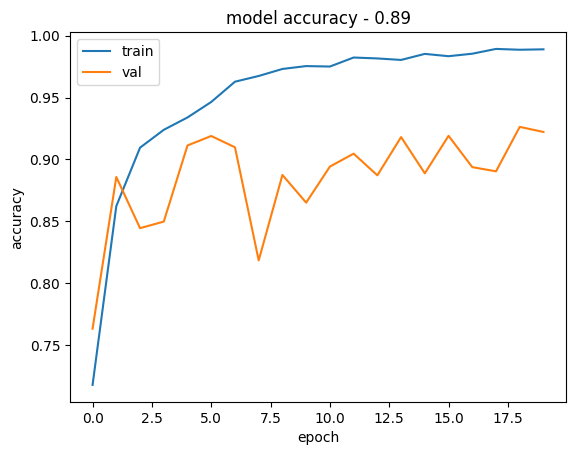

In [14]:
# loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy - ' + str(format(test_accuracy, "0.2f")))
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [15]:
model.save("Mobilenet.h5")

c:\Users\HP\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 1s 981ms/step


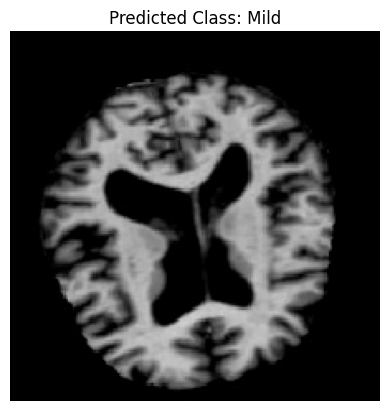

In [18]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_v2_preprocess_input
import matplotlib.pyplot as plt

# Load the saved model
model = load_model(r"C:\Users\HP\OneDrive\Desktop\code\Mobilenet.h5")

# Load an image for prediction
img_path = r"C:\Users\HP\OneDrive\Desktop\code\augmented-alzheimer-mri-dataset\AugmentedAlzheimerDataset\VeryMildDemented\0a1d2c6b-8a59-4e07-879f-fd4f4b76db34.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to create a batch

# Preprocess the image using MobileNetV2 preprocess_input function
preprocessed_img = mobilenet_v2_preprocess_input(img_array)

# Make predictions
predictions = model.predict(preprocessed_img)

# Decode the predictions (if needed)
# Assuming your model predicts class probabilities
class_labels = ['Mild', 'Moderate', 'Non', 'VeryMild']  # Provide your class labels
predicted_class_index = np.argmax(predictions)
predicted_class_label = class_labels[predicted_class_index]

# Plot the image
plt.imshow(img)
plt.title(f'Predicted Class: {predicted_class_label}')
plt.axis('off')  # Hide axis
plt.show()
